In [1]:
import cv2 as cv
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.models as models

In [2]:
torch.cuda.set_device(0)
device = torch.device('cuda')
loss_function = nn.CrossEntropyLoss()

In [3]:
images = torch.tensor(np.load("cropped_images.npy"), dtype=torch.float32)
labels = torch.tensor(np.load("labels.npy"), dtype=torch.long) - 1

split = int(images.shape[0]*0.9)
train_images = images[:split]
train_labels = labels[:split]

val_images = images[split:]
val_labels = labels[split:]

print(train_labels.shape)
print(val_labels.shape)

torch.Size([1213])
torch.Size([135])


In [4]:
class Model(nn.Module):
	def __init__(self):
		super().__init__()
		self.layers = nn.Sequential(
			nn.Conv2d(3, 32, kernel_size=(5, 5), stride=(5, 5)),
			nn.ReLU(),
			nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(3, 3)),
			nn.ReLU(),
			nn.Conv2d(64, 256, kernel_size=(3, 3), stride=(3, 3)),
			nn.ReLU(),
			nn.Flatten(start_dim=1, end_dim=-1),
			nn.Linear(in_features=256, out_features=4, bias=True)
			)
		
		self.reset_params()
		
	@staticmethod
	def weight_init(m):
		if isinstance(m, nn.Conv2d):
			nn.init.xavier_uniform_(m.weight)
			nn.init.constant_(m.bias, 0)

	def reset_params(self):
		for i, m in enumerate(self.modules()):
			self.weight_init(m)
			
	def forward(self, x):
		return self.layers(x)

In [5]:
model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model.to(device)

Model(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(5, 5))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(3, 3))
    (3): ReLU()
    (4): Conv2d(64, 256, kernel_size=(3, 3), stride=(3, 3))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=256, out_features=4, bias=True)
  )
)

In [6]:
def val_loss():
	val_losses = []
	model.eval()
	for i in range(val_images.shape[0]):
		x = val_images[i:i+1]
		y = val_labels[i:i+1]
		
		x = x.to(device)
		y = y.to(device)

		logits = model(x.permute(0, 3, 1, 2))
		loss = loss_function(logits, y)
		val_losses.append(loss.item())
	model.train();
	return sum(val_losses)/len(val_losses)

In [7]:
losses = []

In [8]:
n_epochs = 50
batch_size = 16

for epoch in range(n_epochs):
	permutation = torch.randperm(train_images.shape[0])
	for i in range(0, permutation.shape[0], batch_size):
		optimizer.zero_grad()

		indices = permutation[i:i+batch_size]
		x, y = train_images[indices], train_labels[indices]

		x = x.to(device)
		y = y.to(device)

		logits = model(x.permute(0, 3, 1, 2))
		loss = loss_function(logits, y)
		losses.append(loss.item())
		
		loss.backward()
		optimizer.step()
	print(val_loss())

1.1112475717509234
0.7228419513614089
0.22247533874103317
0.26631214742859205
0.37656267682021416
0.2836037407491218
0.2675899931393495
0.18257681895888203
0.2193414695362595
0.17292743551061668
0.19156238470106338
0.146222077575651
0.18168511418502425
0.17116277164822585
0.16357621026676564
0.17704560618907028
0.192012398797976
0.18167951122671994
0.17141400349770872
0.16051629387065144
0.18938096778519123
0.17769426734827767
0.17610088031393994
0.17025479314129074
0.18247325673147122
0.17295482327188993
0.18071107988691765
0.1921992579368167
0.17377804772374067
0.17992468289305213
0.18613401284829365
0.1827129773422935
0.17715428523601387
0.18230021937117652
0.1773484454342143
0.1780331459718324
0.17883141611814835
0.18362167714219862
0.18480717461771926
0.18434035005320776
0.18821448989220474
0.18631911543254173
0.18426183255585687
0.18788143277988745
0.19263735670083443
0.1893123090474411
0.1961094236254481
0.1882221391343593
0.18831225688249736
0.20035929015041953


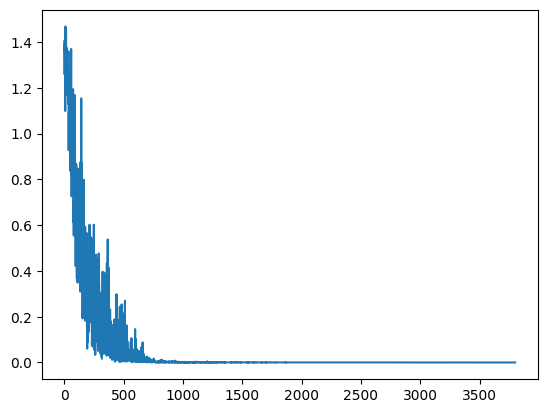

In [9]:
plt.plot(losses)

In [10]:
model.eval()
val_losses = []
for i in range(val_images.shape[0]):
	x = val_images[i:i+1]
	y = val_labels[i:i+1]
	
	x = x.to(device)
	y = y.to(device)

	logits = model(x.permute(0, 3, 1, 2))
	loss = loss_function(logits, y)
	val_losses.append(loss.item())
print(sum(val_losses)/len(val_losses))
model.train();

0.20035929015041953


In [9]:
import csv
files = os.listdir("test")
model.eval()
test_set = torch.tensor(np.load("cropped_test_set.npy"), dtype=torch.float32)
predictions = []
for i in range(test_set.shape[0]):
	t = test_set[i:i+1].to(device)
	l = model(t.permute(0, 3, 1, 2))
	predictions.append(torch.argmax(torch.softmax(l, dim=1)).item()+1)
print(len(predictions))
print(len(files))
dictionary = []
for i in range(len(files)):
	dictionary.append([files[i], predictions[i]])
with open("answers.csv", mode='w', newline='') as file:
	writer = csv.writer(file)
	writer.writerows(dictionary)
model.train();

85
85


Model(
  (embedding): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run